<a href="https://colab.research.google.com/github/ahmedalkordy/KL-High-Rise-Price-Modelling/blob/master/meanShift_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

from skimage.color import rgb2gray
from skimage.metrics import (adapted_rand_error,variation_of_information)
from skimage.filters import sobel
from skimage.measure import label
from skimage.util import img_as_float
from skimage.feature import canny
from skimage.morphology import remove_small_objects
from skimage.segmentation import (morphological_geodesic_active_contour, inverse_gaussian_gradient,
                                  watershed, mark_boundaries)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


(300, 300, 3)


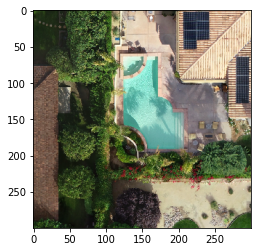

In [3]:
#path0 = '/content/gdrive/My Drive/Adal&Norah-Project-CEN546/sample_images/'
#/content/gdrive/My Drive/CEN546_project_files/image-chips
path0 = '/content/gdrive/My Drive/CEN546_project_files/'
path = path0+'image-chips/'
image = plt.imread(path+'1d4fbe33f3_F1BE1D4184INSPIRE-000000.png')
print(image.shape)
plt.imshow(image)

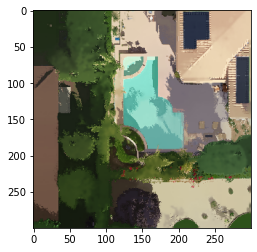

In [0]:
# img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# Z = np.float32(img.reshape((-1,3)))

# img = cv2.pyrMeanShiftFiltering(img, 20, 30, 2)
# img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

# plt.imshow(img)
# plt.show()

[[4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 ...
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]]
[0 1 2 3 4]


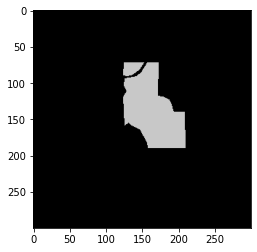

In [4]:
path = path0+'label-chips/'
GT = plt.imread(path+'1d4fbe33f3_F1BE1D4184INSPIRE-000000.png')
GT.shape
image_grount_truth = GT[:,:,0]
GT = np.round(GT*1000)/4
GT = GT.astype('int')
print(GT[:,:,2])
unique_elements = np.unique(GT)
print(unique_elements)
# (075, 025, 230) : BUILDING
# (180, 030, 145) : CLUTTER
# (075, 180, 060) : VEGETATION
# (048, 130, 245) : WATER
# (255, 255, 255) : GROUND
# (200, 130, 000) : CAR
# (255, 000, 255) : IGNORE

plt.imshow((GT==3)*200)

In [5]:
image_reshaped = np.reshape(image , ( image.shape[0]* image.shape[1] , image.shape[2]))
print('image_reshaped shape: ' , image_reshaped.shape)

image_reshaped shape:  (90000, 3)


In [6]:

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(image_reshaped, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(image_reshaped)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# #############################################################################

number of estimated clusters : 4


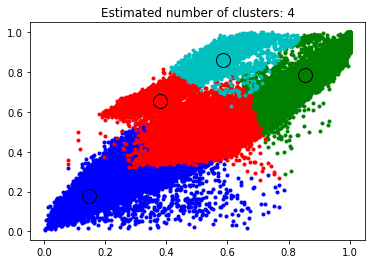

In [7]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(image_reshaped[my_members, 0], image_reshaped[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

(90000,)


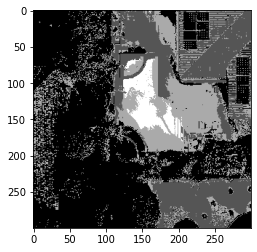

In [8]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

print(labels.shape)
image_segmented = np.reshape(labels, (image.shape[0] , image.shape[1] )  )

plt.imshow(image_segmented*40  , cmap='gray')


[[4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 ...
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]]
[0 1 2 3 4]
[[2 0 0 ... 1 1 1]
 [2 0 0 ... 1 1 1]
 [2 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


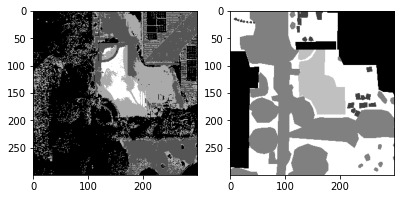

In [9]:
fig1 = plt.figure(figsize=(10,20))  # create a figure object
ax = fig1.add_subplot(1, 3, 1)  # create an axes object in the figure
ax.imshow(image_segmented*40 , cmap='gray')
ax = fig1.add_subplot(1, 3, 2)  # create an axes object in the figure
ax.imshow(GT[:,:,2]*40  , cmap='gray')
# BUILDING:0, CLUTTER:1 , VEGETATION:2, WATER:3, GROUND:4, CAR:5, IGNORE:6

print(GT[:,:,2])
unique_elements = np.unique(GT)
print(unique_elements)
print(image_segmented)

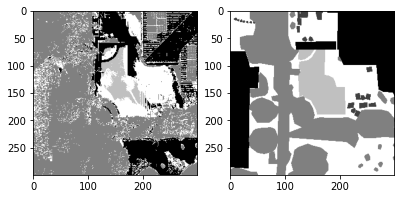

In [10]:
image_segmented_new = np.zeros(image_segmented.shape)
idx = image_segmented==2
image_segmented_new[idx] = 4
idx = image_segmented==0
image_segmented_new[idx] = 2
idx = image_segmented==1
image_segmented_new[idx] = 0
idx = image_segmented==3
image_segmented_new[idx] = 3
image_segmented_new = image_segmented_new.astype(int)
fig1 = plt.figure(figsize=(10,20))  # create a figure object
ax = fig1.add_subplot(1, 3, 1)  # create an axes object in the figure
ax.imshow(image_segmented_new*40 , cmap='gray')
ax = fig1.add_subplot(1, 3, 2)  # create an axes object in the figure
ax.imshow(GT[:,:,0]*40  , cmap='gray')
# BUILDING:0, CLUTTER:1 , VEGETATION:2, WATER:3, GROUND:4, CAR:5, IGNORE:6


In [12]:
gray_original = rgb2gray(image)
# compute metrics
Grount_truth_matrix = GT[:,:,0]
print(Grount_truth_matrix.shape)
print(gray_original.shape)
print(Grount_truth_matrix)
print(image_segmented_new)


error, precision, recall = adapted_rand_error(Grount_truth_matrix, image_segmented_new)
print("Error: " , error*100)
print("precision: " , precision*100)
print("recall: " , recall*100)
splits, merges = variation_of_information(Grount_truth_matrix, image_segmented_new)


from sklearn.metrics import accuracy_score
#ACC = accuracy_score(Grount_truth_matrix, image_segmented_new, normalize=False)
#print("ACC: " , ACC*100)

(300, 300)
(300, 300)
[[4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 ...
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]]
[[4 2 2 ... 0 0 0]
 [4 2 2 ... 0 0 0]
 [4 2 2 ... 0 0 0]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
Error:  44.66977895858177
precision:  54.47617387822543
recall:  56.21147326347911
